In [7]:
# Ячейка 1: Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../src')

from data_loader import DataLoader
from statistical_analyzer import StatisticalAnalyzer

# Настройка визуализации
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [8]:
# Ячейка 2: Загрузка подготовленных данных
print("📊 ЗАГРУЗКА ПОДГОТОВЛЕННЫХ ДАННЫХ...")

df = pd.read_csv('../data/processed/cleaned_marketing_ab.csv')
print(f"Размер данных: {df.shape}")
print(f"Колонки: {list(df.columns)}")
print(f"\nПервые 3 строки:")
print(df.head(3))

📊 ЗАГРУЗКА ПОДГОТОВЛЕННЫХ ДАННЫХ...
Размер данных: (588101, 7)
Колонки: ['unnamed:_0', 'user_id', 'test_group', 'converted', 'total_ads', 'most_ads_day', 'most_ads_hour']

Первые 3 строки:
   unnamed:_0  user_id test_group  converted  total_ads most_ads_day  \
0           0  1069124         ad      False        130       Monday   
1           1  1119715         ad      False         93      Tuesday   
2           2  1144181         ad      False         21      Tuesday   

   most_ads_hour  
0             20  
1             22  
2             18  


In [10]:
# Ячейка 3: Инициализация анализатора
analyzer = StatisticalAnalyzer(df)

TypeError: StatisticalAnalyzer() takes no arguments

In [ ]:
# Ячейка 4: SRM проверка (Sample Ratio Mismatch)
print("🔍 SRM ПРОВЕРКА (Sample Ratio Mismatch)")

# Пример с кастомными пропорциями (можно менять)
expected_ratios = {'ad': 0.96, 'psa': 0.9}

# Вызов проверки SRM
srm_results = analyzer.validate_srm(expected_ratios=expected_ratios)

# Вывод результатов
print(f"Результат: {srm_results['message']}")
print(f"P-value: {srm_results['p_value']:.6f}")
print("\nРаспределение по группам:")
for group, count in srm_results['group_counts'].items():
    percentage = count / sum(srm_results['group_counts'].values()) * 100
    expected_percentage = srm_results['expected_counts'][group] / sum(srm_results['expected_counts'].values()) * 100
    print(f"  {group}: {count} ({percentage:.1f}%), ожидаемое: {expected_percentage:.1f}%")


🔍 SRM ПРОВЕРКА (Sample Ratio Mismatch)


ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1.4901161193847656e-08, but the percent differences are:
0.8599999999999998

In [ ]:
# Ячейка 5: Расчет конверсии по группам
print("🎯 РАСЧЕТ КОНВЕРСИИ ПО ГРУППАМ")
conversion_rates = analyzer.calculate_conversion_rates()

for group, metrics in conversion_rates.items():
    if group in ['ad', 'psa']:
        print(f"\n{group.upper()} группа:")
        print(f"  Конверсий: {metrics['conversions']}/{metrics['total']}")
        print(f"  Конверсия: {metrics['conversion_percentage']:.3f}%")
        print(f"  Rate: {metrics['conversion_rate']:.4f}")

if 'difference' in conversion_rates:
    diff = conversion_rates['difference']
    print(f"\n📈 РАЗНИЦА:")
    print(f"  Абсолютная: {diff['absolute']:.4f}")
    print(f"  Относительная: {diff['relative']:.2f}%")

🎯 РАСЧЕТ КОНВЕРСИИ ПО ГРУППАМ

AD группа:
  Конверсий: 14423/564577
  Конверсия: 2.555%
  Rate: 0.0255

PSA группа:
  Конверсий: 420/23524
  Конверсия: 1.785%
  Rate: 0.0179

📈 РАЗНИЦА:
  Абсолютная: 0.0077
  Относительная: 43.09%


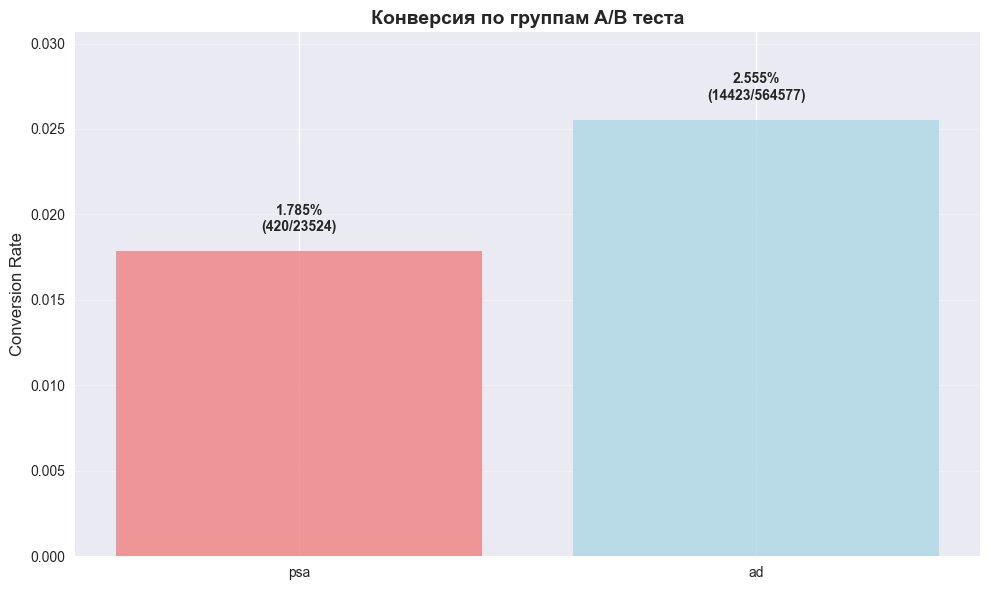

In [ ]:
# Ячейка 6: Визуализация конверсии
plt.figure(figsize=(10, 6))

# Данные для графика
groups = ['psa', 'ad']
rates = [conversion_rates[g]['conversion_rate'] for g in groups]
conversions = [conversion_rates[g]['conversions'] for g in groups]
totals = [conversion_rates[g]['total'] for g in groups]

bars = plt.bar(groups, rates, color=['lightcoral', 'lightblue'], alpha=0.8)

plt.title('Конверсия по группам A/B теста', fontsize=14, fontweight='bold')
plt.ylabel('Conversion Rate', fontsize=12)
plt.ylim(0, max(rates) * 1.2)

# Добавляем значения на столбцы
for bar, rate, conv, total in zip(bars, rates, conversions, totals):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{rate:.3%}\n({conv}/{total})',
             ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Ячейка 7: Статистическая значимость (Z-тест)
print("📊 ПРОВЕРКА СТАТИСТИЧЕСКОЙ ЗНАЧИМОСТИ")
prop_test = analyzer.perform_proportion_test()

print(f"Z-статистика: {prop_test['z_statistic']:.4f}")
print(f"P-value: {prop_test['p_value']:.6f}")
print(f"Статистически значимо: {'✅ ДА' if prop_test['significant'] else '❌ НЕТ'}")

print(f"\nДоверительные интервалы (95%):")
print(f"  AD: [{prop_test['ad_confidence_interval'][0]:.4f}, {prop_test['ad_confidence_interval'][1]:.4f}]")
print(f"  PSA: [{prop_test['psa_confidence_interval'][0]:.4f}, {prop_test['psa_confidence_interval'][1]:.4f}]")
print(f"  Разница: [{prop_test['difference_confidence_interval'][0]:.4f}, {prop_test['difference_confidence_interval'][1]:.4f}]")

📊 ПРОВЕРКА СТАТИСТИЧЕСКОЙ ЗНАЧИМОСТИ
Z-статистика: 7.3701
P-value: 0.000000
Статистически значимо: ✅ ДА

Доверительные интервалы (95%):
  AD: [0.0251, 0.0260]
  PSA: [0.0162, 0.0195]
  Разница: [0.0060, 0.0094]


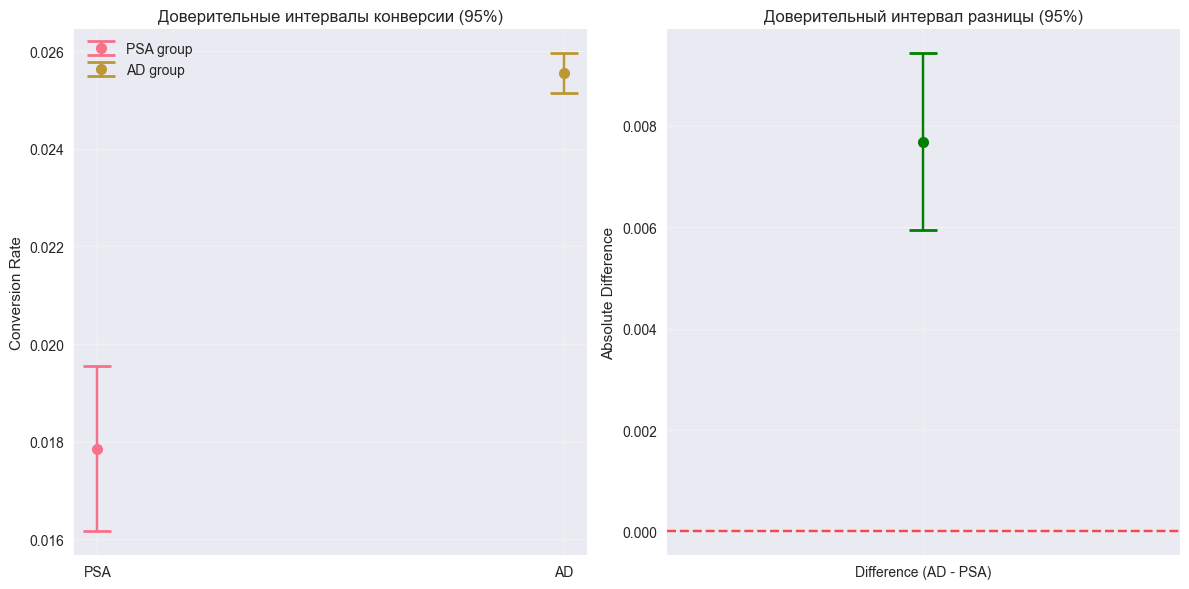

In [ ]:
# Ячейка 8: Визуализация доверительных интервалов
plt.figure(figsize=(12, 6))

# Доверительные интервалы для конверсии
plt.subplot(1, 2, 1)
for i, group in enumerate(['psa', 'ad']):
    ci = prop_test[f'{group.lower()}_confidence_interval']
    rate = conversion_rates[group]['conversion_rate']
    
    plt.errorbar(i, rate, yerr=[[rate - ci[0]], [ci[1] - rate]], 
                 fmt='o', capsize=10, capthick=2, markersize=8,
                 label=f'{group.upper()} group')
    
plt.xticks([0, 1], ['PSA', 'AD'])
plt.ylabel('Conversion Rate')
plt.title('Доверительные интервалы конверсии (95%)')
plt.legend()
plt.grid(alpha=0.3)

# Доверительный интервал для разницы
plt.subplot(1, 2, 2)
diff = conversion_rates['difference']['absolute']
diff_ci = prop_test['difference_confidence_interval']

plt.errorbar(0, diff, yerr=[[diff - diff_ci[0]], [diff_ci[1] - diff]], 
             fmt='o', capsize=10, capthick=2, markersize=8, color='green')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
plt.xticks([0], ['Difference (AD - PSA)'])
plt.ylabel('Absolute Difference')
plt.title('Доверительный интервал разницы (95%)')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Ячейка 9: Bootstrap анализ
print("🔄 BOOTSTRAP АНАЛИЗ")
bootstrap_results = analyzer.bootstrap_analysis(n_bootstrap=5000)

print(f"Средняя разница: {bootstrap_results['mean_difference']:.6f}")
print(f"95% ДИ: [{bootstrap_results['confidence_interval_95'][0]:.6f}, {bootstrap_results['confidence_interval_95'][1]:.6f}]")
print(f"90% ДИ: [{bootstrap_results['confidence_interval_90'][0]:.6f}, {bootstrap_results['confidence_interval_90'][1]:.6f}]")
print(f"Bootstrap p-value: {bootstrap_results['p_value']:.6f}")

🔄 BOOTSTRAP АНАЛИЗ


KeyboardInterrupt: 

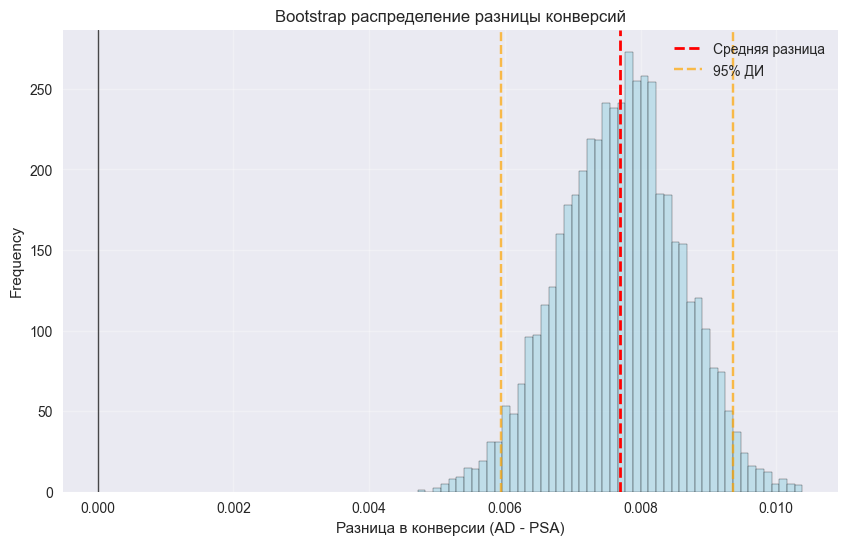

In [ ]:
# Ячейка 10: Визуализация bootstrap распределения
plt.figure(figsize=(10, 6))

plt.hist(bootstrap_results['bootstrap_differences'], bins=50, 
         alpha=0.7, color='lightblue', edgecolor='black')
plt.axvline(bootstrap_results['mean_difference'], color='red', 
            linestyle='--', linewidth=2, label='Средняя разница')
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.7)

# Доверительные интервалы
plt.axvline(bootstrap_results['confidence_interval_95'][0], color='orange', 
            linestyle='--', alpha=0.7, label='95% ДИ')
plt.axvline(bootstrap_results['confidence_interval_95'][1], color='orange', 
            linestyle='--', alpha=0.7)

plt.xlabel('Разница в конверсии (AD - PSA)')
plt.ylabel('Frequency')
plt.title('Bootstrap распределение разницы конверсий')
plt.legend()
plt.grid(alpha=0.3)
plt.show()